In [1]:
import ira
import inspect
from dataclasses import dataclass
from typing import Union, List
from datetime import timedelta
import requests

from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection._search import BaseSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

%alphalab dark
from alpha.utils.data_helpers import FriendlyFxLoader
from qlearn.core.base import MarketDataComposer
from qlearn.core.pickers import SingleInstrumentPicker
from qlearn.core.utils import debug_output
from ira.utils.ui_utils import *

Reloaded /usr/local/envs/ira_p36/lib/python3.6/site-packages/ira/experimental/c_simulator_core.pyx


In [2]:
from multiprocessing import Manager
import multiprocessing as mp

In [3]:
data = z_load('ticks/BITMEX:XBTUSD')['data']

In [37]:
def _proc_run(v1):
    return v1

In [38]:
n_cpu = min(mp.cpu_count(), 1000)
pool = mp.Pool(n_cpu)
results_iterator = pool.imap_unordered(_proc_run, [
    (1,2), 
    (100,34)
])

In [40]:
for result in results_iterator:
    if result is not None:  # new result is ready
        print(result)

In [19]:
from  multiprocessing.managers import BaseManager
import psutil   #3rd party module for process info (not strictly required)

# Grab the shared proxy class.  All methods in that class will be availble here
class DataClient:
    def __init__(self, port):
        class myManager(BaseManager): pass
        myManager.register('DataProxy')
        self.mgr = myManager(address=('localhost', port), authkey=bytes('dp000', encoding='utf8'))
#         self.mgr = myManager(address=('localhost', port))
        self.mgr.connect()
        self.proxy = self.mgr.DataProxy()

In [20]:
dc  = DataClient(5001)

In [ ]:
dc.proxy.set_data('b', {'XBTUSD': [1,2,3]})

In [ ]:
dc.proxy.get_data('a')

In [33]:
pfl = z_load('MR_1hr_live', dbname='trading_portfolio_logs')['data']


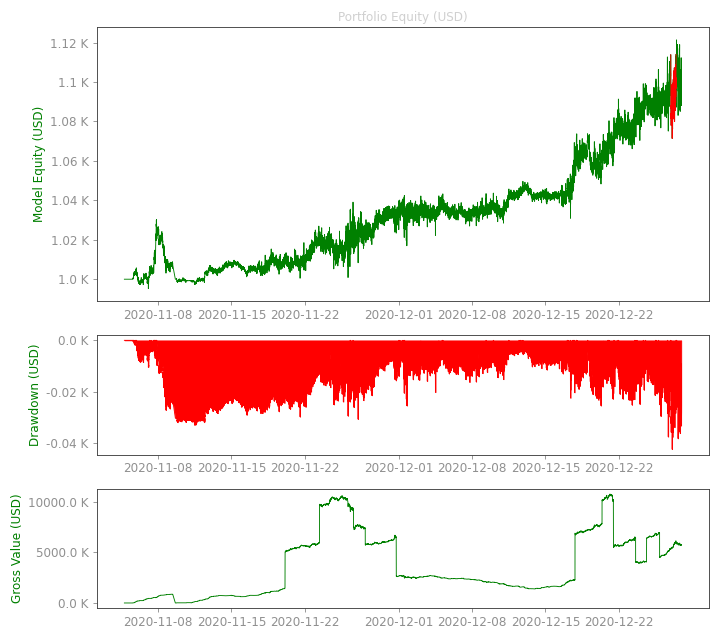

<Figure size 720x640 with 0 Axes>

In [41]:
tearsheet(split_cumulative_pnl(pfl)[:'2020-12-27'], 1000)

In [21]:
# z_ls('.*', host='atlas.appliedalpha.com')
# z_ls('.*', host='neptun.appliedalpha.com', dbname='IRA_trading_portfolio')
# z_ls('.*', host='neptun.appliedalpha.com', dbname='IRA_trading_portfolio_logs')
exec_id = 'dukas_new@GridScalping'
execs = z_load(exec_id, host='neptun.appliedalpha.com', dbname='IRA_trading_execution_logs')['data']
portfolio = z_load(exec_id, host='neptun.appliedalpha.com', dbname='IRA_trading_portfolio')['data']
portfolio_log = z_load(exec_id, host='neptun.appliedalpha.com', dbname='IRA_trading_portfolio_logs')['data']

In [ ]:
from ira.utils.nb_functions import z_load

In [28]:
portfolio_log.AllocatedTotalBpAmountUsd[-1] 

50000.0

In [ ]:
portfolio.to_html()

In [15]:
from ira.analysis.portfolio import split_cumulative_pnl

/usr/local/envs/ira_p36/lib/python3.6/site-packages/ira/analysis/portfolio.py:165: RuntimeWarning:

divide by zero encountered in double_scalars




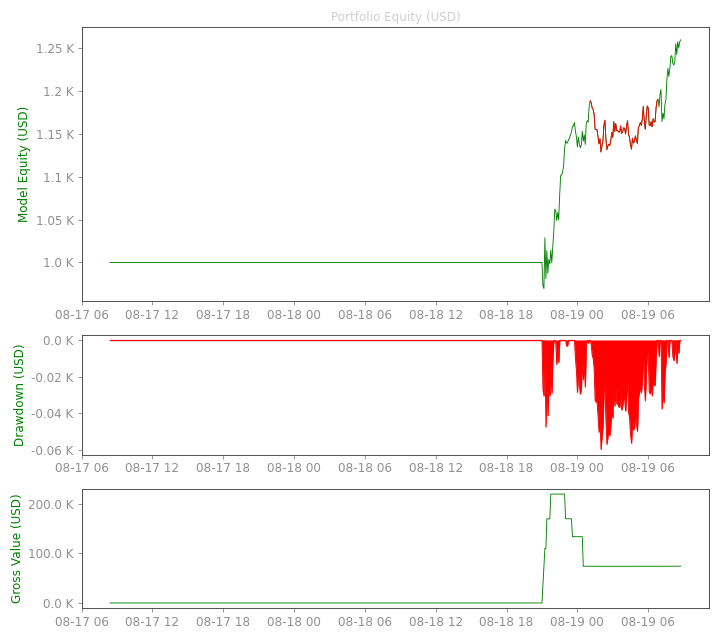

<Figure size 720x640 with 0 Axes>

In [16]:
tearsheet(split_cumulative_pnl(portfolio_log), 1000)

In [23]:
data = FriendlyFxLoader('dukas @ 5Min').ohlcs(['EURUSD'])

In [24]:
debug_output(data['EURUSD'], 'H')

.-<H 515219 records | 2014-01-01 22:00:00:2020-11-26 23:55:00 records>- - - - - - - - - - - - - - - 
                         open     high       low     close  volume
time                                                              
2014-01-01 22:00:00  1.375950  1.37603  1.375390  1.375430      38
2014-01-01 22:05:00  1.375430  1.37626  1.375385  1.375685      27
2014-01-01 22:10:00  1.375605  1.37580  1.374065  1.375365     106
 	 ...  
time                 1.19100  1.191055  1.191000  1.191045  40
2020-11-26 23:45:00  1.19105  1.191200  1.191035  1.191195  25
2020-11-26 23:50:00  1.19121  1.191220  1.191090  1.191105  50
2020-11-26 23:55:00                                           
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


In [107]:
@dataclass
class MarketInfo:
    symbols: Union[List[str], None]
    column: str
    timezone: str = 'UTC'
    session_start = timedelta(hours=0, minutes=0)
    session_end = timedelta(hours=23, minutes=59, seconds=58)
    tick_sizes: dict = None
    tick_prices: dict = None

In [148]:
def pre_close_time_delta(freq):
    return _S1 if freq > _S1 else freq / 10

def pre_close_time_shift(bars):
    _tshift = pd.Timedelta(infer_series_frequency(bars[:100]))
    return _tshift - pre_close_time_delta(_tshift)

def predict(func):
    def wrapped_predict(obj, xp, *args, **kwargs):
        yh = func(obj, xp, *args, **kwargs)
        if not hasattr(obj, 'exact_time') and obj.metadata().column == 'close':
            yh = yh.shift(1, freq=pre_close_time_shift(xp))

        return yh
    return wrapped_predict


def signal_generator(cls):
    m = inspect.getmembers(cls, lambda x: (inspect.isfunction(x) or inspect.ismethod(x)) and x.__name__ == 'predict')
    if m:
        setattr(cls, m[0][0], predict(m[0][1]))
    cls.__qlearn__ = '0.0.1'
    cls.market_info_: MarketInfo = None
    return cls

In [242]:
class MidDayPrice(TransformerMixin):
    def fit(self, x, y, **kwargs):
        return self

    def transform(self, x):
        return x.assign(mid = .5*(x.high+x.low))
    
class Ema(TransformerMixin, BaseEstimator):
    def __init__(self, period):
        self.period = period
        self.__qlearn__ = 1
        
    def fit(self, x, y, **kwargs):
        return self

    def transform(self, x):
        return x.assign(**{f'MA{self.period}': apply_to_frame(ema, x.close, self.period)})

@signal_generator
class TesterSingle(BaseEstimator):
    def __init__(self, period):
        self.period = period

    def fit(self, X, y, **fit_params):
        self.market_info_ = fit_params['market_info_']
        return self

    def predict(self, X):
        print(self._market_info)
        price = X[self.market_info_.column]
#         self.exact_time = 1
        return srows(
            pd.Series(+1, price[(price > price.shift(self.period))].index),
            pd.Series(-1, price[(price < price.shift(self.period))].index))


In [191]:
mdc = MarketDataComposer(predictor, SingleInstrumentPicker())

In [ ]:
mdc.fit(data, None) 

In [ ]:
predictor.fit(data['EURUSD'], pd.Series(0, data['EURUSD'].index), **{f'{elst[0][0]}__market_info_': 123})

In [233]:
predictor.best_estimator_.steps[-1][1].steps[-1][1].steps[-1][1].market_info_

123

In [4]:
d = data['EURUSD']

In [258]:
dp = d.close.shift(1) - d.close

In [ ]:
dp.where(abs(dp) >= 0, 0)

In [274]:
from tqdm.notebook import tqdm

In [28]:
z_del('results/JKBasicModel')

In [8]:
def proc(line, cell=None):ke 
    import multiprocessing as m
    import time, re

    # create ext args
    if line:
        ipy = get_ipython()
        for a in [x for x in re.split('[\ ,;]', line.strip()) if x]:
            ipy.push({a: self._get_manager().Value(None, None)})

    # code to run
    lines = '\n'.join(['    %s' % x for x in cell.split('\n')])

    def fn():
        result = get_ipython().run_cell(lines)

        # send errors to parent
        if result.error_before_exec:
            raise result.error_before_exec
        if result.error_in_exec:
            raise result.error_in_exec

    t_start = time.time()
    f_id = 'proc_' + str(t_start).replace('.', '_')
    task = m.Process(target=fn, name=f_id)
    task.start()
    print(' -> Task %s started' % f_id)


<hr/>

In [214]:
fxl = FriendlyFxLoader('dukas @ 5Min')
data = fxl.ohlcs(['EURUSD', 'GBPUSD'])

In [6]:
from sklearn.pipeline import make_pipeline
from copy import deepcopy, copy

from qlearn.core.base import signal_generator
from qlearn.core.data_utils import make_dataframe_from_dict, pre_close_time_shift
from qlearn.core.utils import debug_output

from sklearn.base import BaseEstimator

In [252]:
x = ohlc_resample(data['GBPUSD'], '5Min')

In [310]:
period, smoothing = 5, 5
c = x.close
pos = (c > c.shift(period)) + 0
neg = (c < c.shift(period)) + 0
s_pos, s_neg = pos.rolling(period).sum(), neg.rolling(period).sum()

T = period * (1 - 0.05)
print(T)
osi = apply_to_frame(ema, pos.rolling(period).sum() - neg.rolling(period).sum(), smoothing)
# osi = apply_to_frame(ema, ((s_pos - s_neg) / (s_pos + s_neg)).dropna(), smoothing)
# T = 0.9

if False:
    sx = pd.Series(np.nan, osi.index)
    sx[(osi.shift(1) > T) & (osi.shift(1) > osi)] = -1
    sx[(osi.shift(1) < -T) & (osi.shift(1) < osi)] = 1
else:
    sx = srows(
        pd.Series(+1, osi[(osi.shift(2) > -T) & (osi.shift(1) > -T) & (osi <= -T)].index),
        pd.Series(-1, osi[(osi.shift(2) < +T) & (osi.shift(1) < +T) & (osi >= +T)].index)
    )

sx = sx.dropna()
lo, sh = c.loc[sx[sx > 0].index], c.loc[sx[sx < 0].index]

ss = srows(pd.DataFrame(lo.rename('exec_price')).assign(quantity=1), pd.DataFrame(sh.rename('exec_price')).assign(quantity=-1))
ss = ss[ss.quantity.diff()!=0]

In [321]:
-pd.Series([True, False])

0    False
1     True
dtype: bool

In [311]:
g = LookingGlass([x, ss], {'osi': [osi, -T, T]}, backend='plotly')

# g.look('2020-05-03', '2020-05-08')
g.look('2020-05-11', '2020-05-16')

FigureWidget({
    'data': [{'close': array([1.241375, 1.241195, 1.24156 , ..., 1.210475, 1.21029 , 1.21065 ])…

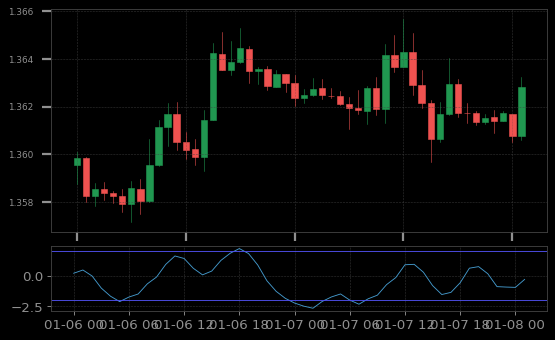

In [11]:

sbp(41,1,r=3); ohlc_plot(x[50:100])
sbp(41,4,1); 
plt.plot(osi[50:100])
plt.axhline(2)
plt.axhline(-2)

<hr/>